<a href="https://colab.research.google.com/github/Surajjoshi2004/Surajjoshi2004/blob/main/poweoutageproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA PREPROCESSING

In [ ]:
import pandas as pd

# Load datasets
power_data = pd.read_csv('power_usage_2016_to_2020.csv')
weather_data = pd.read_csv('weather_2016_2020_daily.csv')

# Convert date columns to datetime
power_data['StartDate'] = pd.to_datetime(power_data['StartDate'])
weather_data['Date'] = pd.to_datetime(weather_data['Date'])

# Aggregate power usage data to daily level
power_data['Date'] = power_data['StartDate'].dt.date
daily_power = power_data.groupby('Date').agg({'Value (kWh)': 'sum'}).reset_index()
daily_power['Date'] = pd.to_datetime(daily_power['Date'])

# Merge weather data with daily power usage
merged_data = pd.merge(weather_data, daily_power, on='Date', how='inner')

# Keep only relevant columns (excluding pressure to avoid error)
columns_to_keep = [
    'Date',
    'Temp_avg',
    'Dew_avg',
    'Hum_avg',
    'Wind_avg',
    'Precipit',
    'Value (kWh)'
]

# Filter the dataset
cleaned_data = merged_data[columns_to_keep]

# Show cleaned data
print("✅ Final Cleaned Data Sample:")
print(cleaned_data.head())


✅ Final Cleaned Data Sample:
        Date  Temp_avg  Dew_avg  Hum_avg  Wind_avg  Precipit  Value (kWh)
0 2016-01-06      74.8     71.4     89.4       9.5      0.00       29.691
1 2016-02-06      71.2     70.3     96.8       7.8      4.33       28.789
2 2016-03-06      72.1     70.0     93.6       4.7      3.18       19.247
3 2016-04-06      71.2     70.0     96.1       7.0      2.37       22.883
4 2016-05-06      73.8     70.0     88.7       7.7      0.39       25.195


In [ ]:


# Load the cleaned data first (from earlier steps)
# Assuming 'cleaned_data' is already prepared with merged power + weather data

# Sort by date
cleaned_data = cleaned_data.sort_values('Date')

# 1. Lag Features
cleaned_data['Prev_Day_Usage'] = cleaned_data['Value (kWh)'].shift(1)

# 2. Change Features
cleaned_data['Usage_Diff'] = cleaned_data['Value (kWh)'] - cleaned_data['Prev_Day_Usage']
cleaned_data['Usage_Pct_Change'] = (cleaned_data['Usage_Diff'] / cleaned_data['Prev_Day_Usage']) * 100

# 3. Rolling Window Features (7-day)
cleaned_data['Usage_Rolling_Mean'] = cleaned_data['Value (kWh)'].rolling(window=7).mean()
cleaned_data['Usage_Rolling_Std'] = cleaned_data['Value (kWh)'].rolling(window=7).std()

# 4. Z-score for usage
cleaned_data['Usage_Z_Score'] = (
    (cleaned_data['Value (kWh)'] - cleaned_data['Usage_Rolling_Mean']) / cleaned_data['Usage_Rolling_Std']
)

# 5. Flags for Spikes & Dips
cleaned_data['Outage_Flag'] = cleaned_data['Usage_Z_Score'].apply(lambda z: 1 if z <= -2 else 0)
cleaned_data['Spike_Flag'] = cleaned_data['Usage_Z_Score'].apply(lambda z: 1 if z >= 2 else 0)

# 6. Weather-Related Flags
cleaned_data['Heavy_Rain'] = (cleaned_data['Precipit'] > 10).astype(int)
cleaned_data['High_Wind'] = (cleaned_data['Wind_avg'] > 30).astype(int)
cleaned_data['Extreme_Temp'] = ((cleaned_data['Temp_avg'] < 5) | (cleaned_data['Temp_avg'] > 40)).astype(int)

# 7. Day-of-week flags
cleaned_data['DayOfWeek'] = cleaned_data['Date'].dt.dayofweek
cleaned_data['Is_Weekend'] = cleaned_data['DayOfWeek'].isin([5, 6]).astype(int)

# 8. High Demand Weather flag
cleaned_data['High_Demand_Weather'] = ((cleaned_data['Temp_avg'] > 35) | (cleaned_data['Temp_avg'] < 5)).astype(int)

# 9. Unexpected Low Usage when demand should be high
cleaned_data['Unexpected_Low_Usage'] = (
    (cleaned_data['Value (kWh)'] < cleaned_data['Usage_Rolling_Mean'] - 2 * cleaned_data['Usage_Rolling_Std']) &
    (cleaned_data['High_Demand_Weather'] == 1)
).astype(int)

# 10. Final Composite Outage Signal
cleaned_data['Likely_Outage'] = (
    (cleaned_data['Outage_Flag'] == 1) &
    ((cleaned_data['Heavy_Rain'] == 1) |
     (cleaned_data['High_Wind'] == 1) |
     (cleaned_data['Extreme_Temp'] == 1)) &
    (cleaned_data['Is_Weekend'] == 0)
).astype(int)

# ✅ Done! Show sample output
print(cleaned_data[['Date', 'Value (kWh)', 'Usage_Z_Score', 'Heavy_Rain', 'High_Wind',
                    'Extreme_Temp', 'Is_Weekend', 'Likely_Outage']].head(15))


          Date  Value (kWh)  Usage_Z_Score  Heavy_Rain  High_Wind  \
0   2016-01-06       29.691            NaN           0          0   
30  2016-01-07       43.177            NaN           0          0   
61  2016-01-08       50.057            NaN           0          0   
92  2016-01-09       47.363            NaN           0          0   
122 2016-01-10       42.203            NaN           0          0   
153 2016-01-11       21.535            NaN           0          0   
183 2016-01-12       12.981      -1.582499           0          0   
1   2016-02-06       28.789      -0.449813           0          0   
31  2016-02-07       59.410       1.307234           0          0   
62  2016-02-08       47.570       0.633569           0          0   
93  2016-02-09       24.097      -0.590519           0          0   
123 2016-02-10       23.944      -0.443962           0          0   
154 2016-02-11       27.476      -0.287238           0          0   
184 2016-02-12       11.611      -

In [ ]:
print(cleaned_data[cleaned_data['Likely_Outage'] == 1][['Date', 'Value (kWh)', 'Usage_Z_Score', 'Heavy_Rain', 'High_Wind', 'Extreme_Temp', 'Likely_Outage']])

           Date  Value (kWh)  Usage_Z_Score  Heavy_Rain  High_Wind  \
142  2016-10-21       16.286      -2.140253           0          0   
817  2018-08-27       37.409      -2.029993           0          0   
953  2019-10-01        9.809      -2.197835           0          0   
1313 2020-05-01        9.750      -2.094096           0          0   

      Extreme_Temp  Likely_Outage  
142              1              1  
817              1              1  
953              1              1  
1313             1              1  


🧾 Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1498 entries, 0 to 1472
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1498 non-null   datetime64[ns]
 1   Temp_avg              1498 non-null   float64       
 2   Dew_avg               1498 non-null   float64       
 3   Hum_avg               1498 non-null   float64       
 4   Wind_avg              1498 non-null   float64       
 5   Precipit              1498 non-null   float64       
 6   Value (kWh)           1498 non-null   float64       
 7   Prev_Day_Usage        1497 non-null   float64       
 8   Usage_Diff            1497 non-null   float64       
 9   Usage_Pct_Change      1497 non-null   float64       
 10  Usage_Rolling_Mean    1492 non-null   float64       
 11  Usage_Rolling_Std     1492 non-null   float64       
 12  Usage_Z_Score         1492 non-null   float64       
 13  Outage_Fla

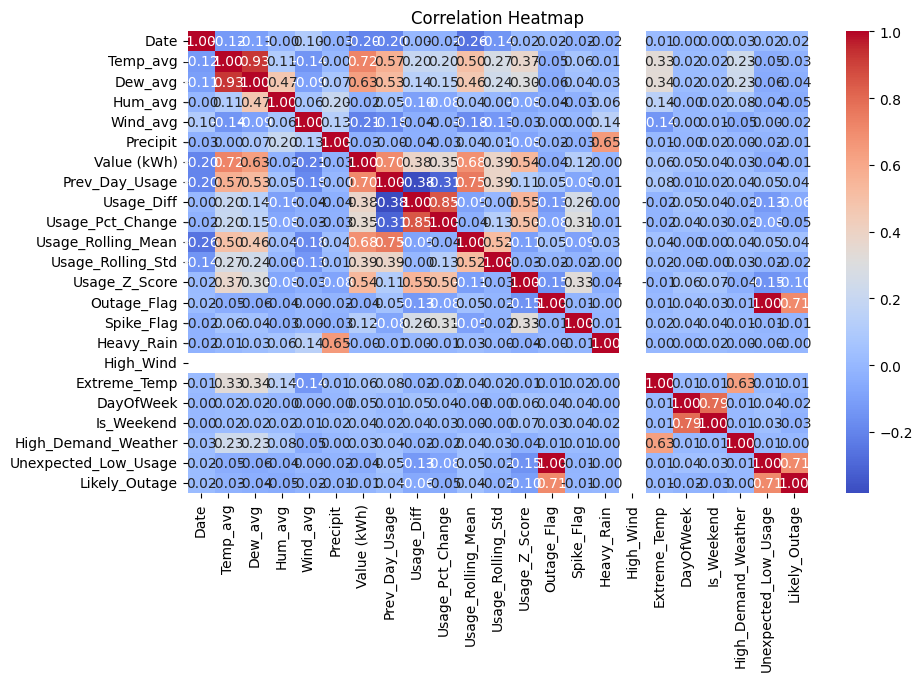

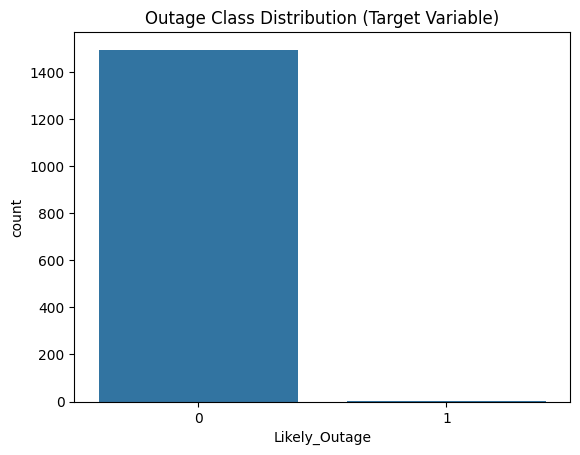

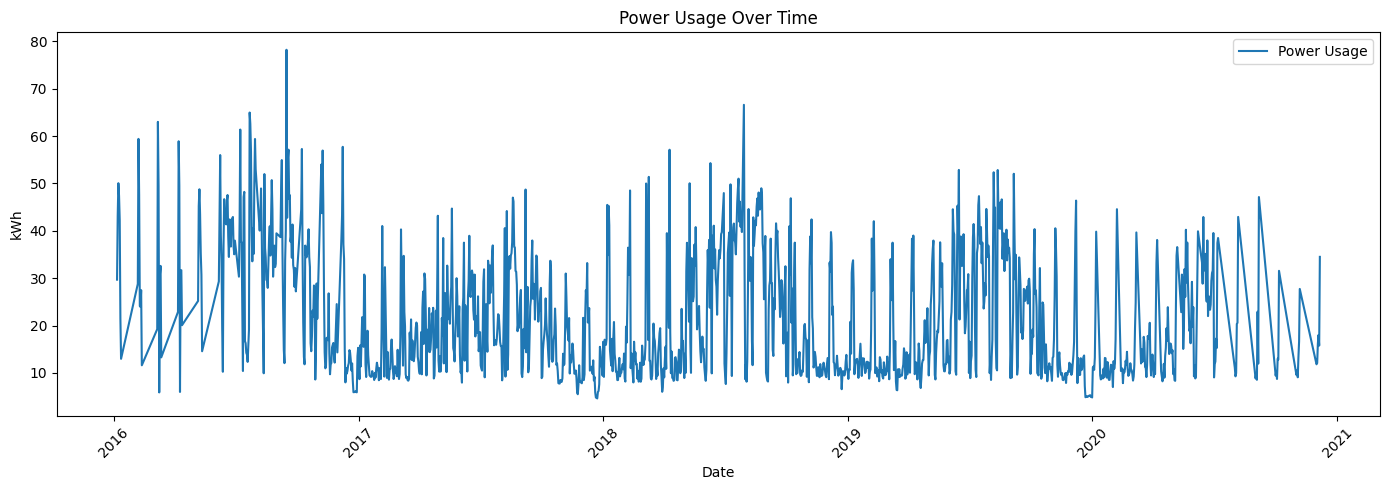

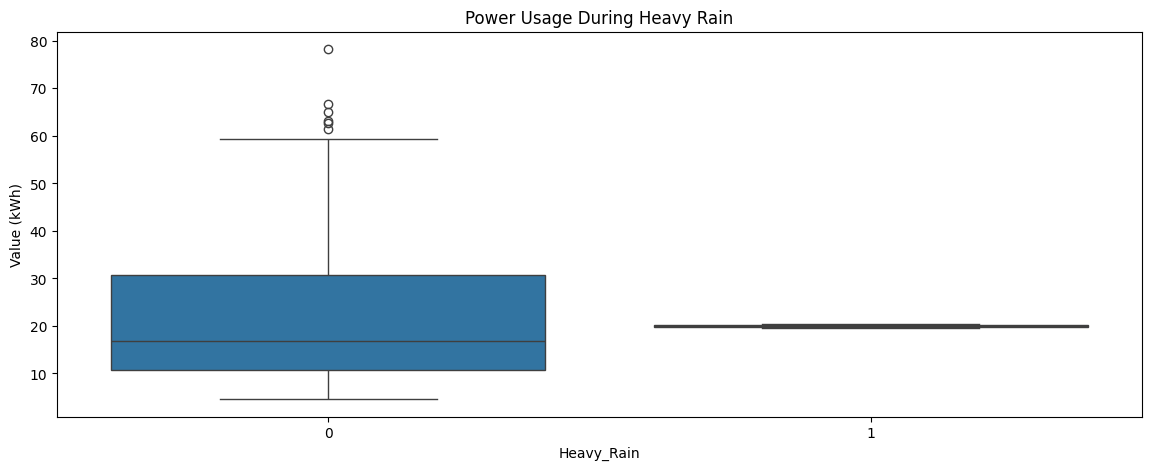

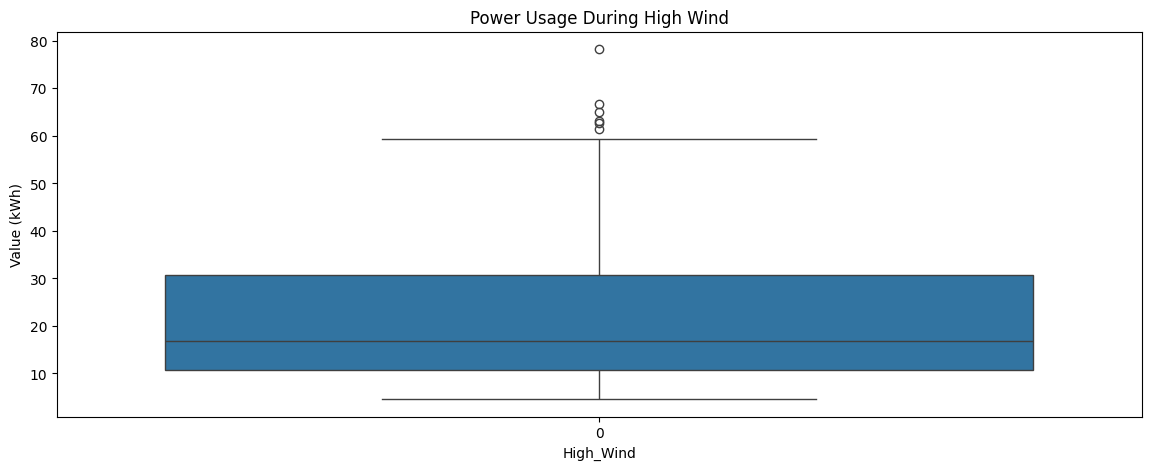

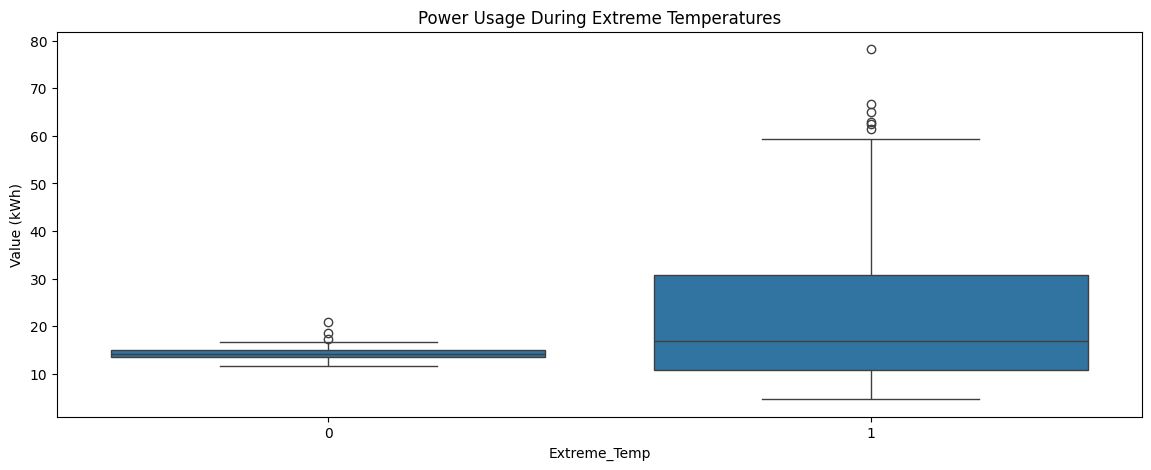

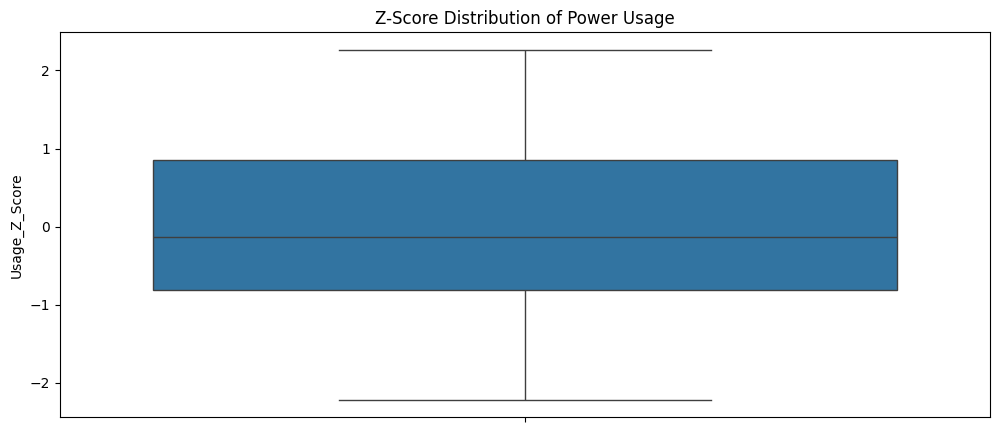

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make sure this is your working dataframe
df = cleaned_data.copy()

# 1. Basic info
print("🧾 Data Info:")
print(df.info())
print("\n📊 Summary Stats:")
print(df.describe())

# 2. Check for null values
print("\n🕳️ Null Values:")
print(df.isnull().sum())

# 3. Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

# 4. Outage class distribution
sns.countplot(data=df, x='Likely_Outage')
plt.title("Outage Class Distribution (Target Variable)")
plt.show()

# 5. Power Usage Over Time
plt.figure(figsize=(14,5))
df_sorted = df.sort_values(by='Date')
plt.plot(df_sorted['Date'], df_sorted['Value (kWh)'], label='Power Usage')
plt.title("Power Usage Over Time")
plt.xlabel("Date")
plt.ylabel("kWh")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Usage During Heavy Rain / High Wind / Extreme Temp
plt.figure(figsize=(14,5))
sns.boxplot(x='Heavy_Rain', y='Value (kWh)', data=df)
plt.title("Power Usage During Heavy Rain")
plt.show()

plt.figure(figsize=(14,5))
sns.boxplot(x='High_Wind', y='Value (kWh)', data=df)
plt.title("Power Usage During High Wind")
plt.show()

plt.figure(figsize=(14,5))
sns.boxplot(x='Extreme_Temp', y='Value (kWh)', data=df)
plt.title("Power Usage During Extreme Temperatures")
plt.show()

# 7. Z-Score based boxplot
plt.figure(figsize=(12,5))
sns.boxplot(y='Usage_Z_Score', data=df)
plt.title("Z-Score Distribution of Power Usage")
plt.show()


🎯 Classification Report (threshold = 0.001):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       449
           1       0.05      1.00      0.10         1

    accuracy                           0.96       450
   macro avg       0.53      0.98      0.54       450
weighted avg       1.00      0.96      0.98       450


🧩 Confusion Matrix:
[[431  18]
 [  0   1]]


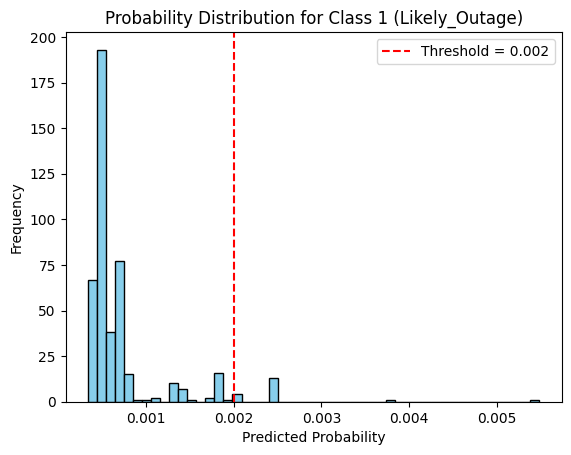

In [103]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 📦 Assume cleaned_data already exists
df = cleaned_data.copy()

# 🎯 Target variable
target = 'Likely_Outage'

# 🔍 Drop non-numeric or unnecessary columns
if 'Date' in df.columns:
    df = df.drop('Date', axis=1)

# 🧼 Separate features and target
X = df.drop(target, axis=1)
y = df[target]

# 🔀 Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 🚀 Train XGBoost model
model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 🔮 Predict probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# ⚙️ Adjust threshold (try 0.1 or 0.05)
threshold = 0.002
y_pred = (y_proba >= threshold).astype(int)

# 📊 Evaluation
print("🎯 Classification Report (threshold = 0.001):")
print(classification_report(y_test, y_pred))

print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 📈 Visualize predicted probabilities
plt.hist(y_proba, bins=50, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")
plt.title("Probability Distribution for Class 1 (Likely_Outage)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()
